In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [3]:
from pettingzoo.test import parallel_api_test
from solution.custom_gym import CustomGymEnviornment
from solution.trainer import *
from solution.policy_net import *

In [4]:
from core.agent import *
from core.world import * 
from core.render import * 
from core.skill import * 
from core.models import *
from core.message import *

In [5]:
DEVICE = "cuda"

In [6]:
from sar.sar_agent import *
from sar.sar_world import *
from sar.sar_env_params import *
from sar.sar_traits_sampler import *

belief_initializer = SARBeliefInitializer(BELIEF_DIMS)
trait_sampler = SARTraitSampler()

def initialize_swarm(world : BaseWorld):
    swarm = trait_sampler.generate(SWARM_SIZE, DEVICE)
    for agent in swarm:
        agent.set_utility(SARUtilityFunction())
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    swarm = belief_initializer.initialize_beliefs(swarm)

In [7]:

from sar.urban_gen import * 
from sar.victims import * 
from sar.sar_comm import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)
def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)
    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)

    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [8]:
from sar.energy import EnergyModel
from sar.victims import VictimModel
from solution.sar_action_interpreter import *
from solution.encoder_net import *
from solution.decoder_net import *
from models.complex_model import * 

world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

In [9]:
policy_net= PolicyNet(1, 7, 4)
target_net=  PolicyNet(1, 7, 4)
encoder_model = Encoder()
decoder_model = Decoder()

complex_model = ComplexModel(
    policy_net= policy_net, 
    encoder_net = encoder_model, 
    decoder_net = decoder_model
)

comms_protocol = SARCommunicationProtocol(encoder_model, decoder_model)
action_interpreter = SARActionInterpreter(BELIEF_DIMS)

custom_gym : CustomGymEnviornment = CustomGymEnviornment(world, action_interpreter, comms_protocol)

complex_model.to(DEVICE)
custom_gym.to(DEVICE)

In [10]:
custom_gym.reset(42)

({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 0., 1., 0., 1.],
          [1., 0., 0., 0., 1., 1., 1.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 1., 0.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 1., 0., 1.]]),
   'State': tensor([90.3885,  0.0000], device='cuda:0')},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [1., 1., 1., 1., 0., 1., 0.],
          [1., 0., 0., 0., 0., 0., 1.],
          [1., 1., 0., 1., 1., 0., 0.]]),
   'State': tensor([107.1394,   1.0000], device='cuda:0')},
  3: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 

### Testing

In [11]:
parallel_api_test(custom_gym, num_cycles=1_000)
custom_gym.reset()

Passed Parallel API test


({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 0., 1., 0., 1.],
          [1., 0., 0., 0., 1., 1., 1.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 1., 0.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 1., 0., 1.]]),
   'State': tensor([90.3885,  0.0000], device='cuda:0')},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [1., 1., 1., 1., 0., 1., 0.],
          [1., 0., 0., 0., 0., 0., 1.],
          [1., 1., 0., 1., 1., 0., 0.]]),
   'State': tensor([107.1394,   1.0000], device='cuda:0')},
  3: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 

# Training

In [12]:

from models.base import * 
from models.idqn import * 
from solution.policy_net import PolicyNet
import matplotlib.pyplot as plt

In [13]:
model = IDQN(env = custom_gym,
             feature_extractor= feature_extractor,
             target_net= target_net,
             model= complex_model,
             batch_size=1024,
             device = DEVICE
             )

In [ ]:
rewards = train_loop(custom_gym, model, games=100, optimization_passes = 1, seed=42)

Training on thesis.


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average loss 50.92931130409241
Model has been saved.

Starting evaluation on thesis (num_games=1)


Training Progress:  10%|█         | 1/10 [00:19<02:52, 19.21s/it]

Avg reward: 1030.66  std: 433.49009723406596  coeff : 0.4205946648109618
Avg reward per agent, per game:  {1: 920.0, 2: 630.0, 3: 2152.0, 4: 1388.0, 5: 1438.0, 6: 1280.0, 7: 772.0, 8: 1401.0, 9: 984.0, 10: 1154.0, 11: 1218.0, 12: 1144.0, 13: 795.0, 14: 1180.0, 15: 1127.0, 16: 1231.0, 17: 859.0, 18: 1256.0, 19: 1835.0, 20: 1492.0, 21: 462.0, 22: 1210.0, 23: 510.0, 24: 601.0, 25: 724.0, 26: 1005.0, 27: 1268.0, 28: 809.0, 29: 1092.0, 30: 292.0, 31: 515.0, 32: 1405.0, 33: 1156.0, 34: 672.0, 35: 893.0, 36: 877.0, 37: 208.0, 38: 1114.0, 39: 1138.0, 40: 1454.0, 41: 1019.0, 42: 1002.0, 43: 937.0, 44: 1287.0, 45: 741.0, 46: 1157.0, 47: 1196.0, 48: 540.0, 49: 161.0, 50: 969.0, 51: 1996.0, 52: 346.0, 53: 1904.0, 54: 575.0, 55: 852.0, 56: 828.0, 57: 743.0, 58: 1539.0, 59: 1363.0, 60: 1223.0, 61: 1194.0, 62: 680.0, 63: 858.0, 64: 1080.0, 65: 544.0, 66: 1425.0, 67: 672.0, 68: 891.0, 69: 1279.0, 70: 736.0, 71: 1178.0, 72: 603.0, 73: 1707.0, 74: 516.0, 75: 827.0, 76: 1890.0, 77: 1326.0, 78: 745.0, 79:

Training Progress:  20%|██        | 2/10 [00:56<03:57, 29.72s/it]

Avg reward: 957.6  std: 388.9453432039006  coeff : 0.40616681621125794
Avg reward per agent, per game:  {1: 1394.0, 2: 1136.0, 3: 1731.0, 4: 1059.0, 5: 1160.0, 6: 1280.0, 7: 1439.0, 8: 1548.0, 9: 721.0, 10: 643.0, 11: 845.0, 12: 1152.0, 13: 691.0, 14: 1503.0, 15: 1296.0, 16: 1228.0, 17: 769.0, 18: 643.0, 19: 1465.0, 20: 1044.0, 21: 843.0, 22: 1210.0, 23: 1472.0, 24: 928.0, 25: 1111.0, 26: 982.0, 27: 813.0, 28: 1278.0, 29: 993.0, 30: 453.0, 31: 947.0, 32: 876.0, 33: 1148.0, 34: 406.0, 35: 679.0, 36: 753.0, 37: 633.0, 38: 1169.0, 39: 2142.0, 40: 1060.0, 41: 741.0, 42: 822.0, 43: 1024.0, 44: 1141.0, 45: 1022.0, 46: 1079.0, 47: 952.0, 48: 446.0, 49: 118.0, 50: 668.0, 51: 2353.0, 52: 808.0, 53: 1165.0, 54: 983.0, 55: 501.0, 56: 896.0, 57: 914.0, 58: 899.0, 59: 1153.0, 60: 870.0, 61: 683.0, 62: 480.0, 63: 865.0, 64: 451.0, 65: 780.0, 66: 976.0, 67: 909.0, 68: 670.0, 69: 488.0, 70: 295.0, 71: 1013.0, 72: 724.0, 73: 744.0, 74: 585.0, 75: 667.0, 76: 1816.0, 77: 1534.0, 78: 1132.0, 79: 556.0, 80

Training Progress:  30%|███       | 3/10 [01:13<02:47, 23.93s/it]

Avg reward: 969.82  std: 425.18154663625745  coeff : 0.43841284633876126
Avg reward per agent, per game:  {1: 484.0, 2: 733.0, 3: 1908.0, 4: 879.0, 5: 953.0, 6: 956.0, 7: 1127.0, 8: 1447.0, 9: 609.0, 10: 534.0, 11: 1449.0, 12: 1470.0, 13: 667.0, 14: 1266.0, 15: 1197.0, 16: 1077.0, 17: 1470.0, 18: 387.0, 19: 1554.0, 20: 942.0, 21: 846.0, 22: 928.0, 23: 1096.0, 24: 610.0, 25: 926.0, 26: 352.0, 27: 1442.0, 28: 761.0, 29: 1357.0, 30: 849.0, 31: 1133.0, 32: 1275.0, 33: 890.0, 34: 884.0, 35: 678.0, 36: 847.0, 37: 451.0, 38: 1452.0, 39: 1536.0, 40: 2487.0, 41: 1104.0, 42: 842.0, 43: 1758.0, 44: 660.0, 45: 959.0, 46: 1084.0, 47: 1135.0, 48: 659.0, 49: 341.0, 50: 1082.0, 51: 1751.0, 52: 818.0, 53: 1725.0, 54: 616.0, 55: 243.0, 56: 667.0, 57: 379.0, 58: 981.0, 59: 1413.0, 60: 1213.0, 61: 693.0, 62: 638.0, 63: 2175.0, 64: 995.0, 65: 661.0, 66: 1068.0, 67: 337.0, 68: 575.0, 69: 763.0, 70: 1706.0, 71: 901.0, 72: 453.0, 73: 1033.0, 74: 756.0, 75: 624.0, 76: 1299.0, 77: 558.0, 78: 1475.0, 79: 418.0, 

Training Progress:  40%|████      | 4/10 [01:41<02:33, 25.58s/it]

Avg reward: 982.56  std: 441.9843508541903  coeff : 0.44982937515692717
Avg reward per agent, per game:  {1: 1229.0, 2: 1429.0, 3: 2451.0, 4: 841.0, 5: 1796.0, 6: 1186.0, 7: 1514.0, 8: 873.0, 9: 854.0, 10: 589.0, 11: 1576.0, 12: 833.0, 13: 1085.0, 14: 1792.0, 15: 854.0, 16: 1364.0, 17: 880.0, 18: 1069.0, 19: 2066.0, 20: 923.0, 21: 586.0, 22: 1255.0, 23: 1508.0, 24: 783.0, 25: 1301.0, 26: 832.0, 27: 1430.0, 28: 1012.0, 29: 1648.0, 30: 640.0, 31: 1074.0, 32: 1017.0, 33: 1085.0, 34: 913.0, 35: 737.0, 36: 1036.0, 37: 608.0, 38: 927.0, 39: 1180.0, 40: 1205.0, 41: 486.0, 42: 654.0, 43: 1483.0, 44: 996.0, 45: 1023.0, 46: 2108.0, 47: 1206.0, 48: 370.0, 49: 543.0, 50: 738.0, 51: 1353.0, 52: 533.0, 53: 1723.0, 54: 410.0, 55: 445.0, 56: 349.0, 57: 295.0, 58: 1455.0, 59: 1579.0, 60: 470.0, 61: 608.0, 62: 1860.0, 63: 1197.0, 64: 976.0, 65: 523.0, 66: 1276.0, 67: 723.0, 68: 661.0, 69: 362.0, 70: 296.0, 71: 558.0, 72: 573.0, 73: 565.0, 74: 615.0, 75: 1016.0, 76: 1267.0, 77: 853.0, 78: 712.0, 79: 486.

Training Progress:  50%|█████     | 5/10 [02:11<02:15, 27.09s/it]

Avg reward: 1003.93  std: 416.2702789054247  coeff : 0.41464074079410385
Avg reward per agent, per game:  {1: 1473.0, 2: 721.0, 3: 1928.0, 4: 941.0, 5: 1741.0, 6: 1344.0, 7: 1039.0, 8: 1235.0, 9: 406.0, 10: 777.0, 11: 571.0, 12: 1472.0, 13: 869.0, 14: 1168.0, 15: 1884.0, 16: 1206.0, 17: 1355.0, 18: 1660.0, 19: 2055.0, 20: 1310.0, 21: 1146.0, 22: 1563.0, 23: 862.0, 24: 580.0, 25: 675.0, 26: 815.0, 27: 1208.0, 28: 1198.0, 29: 745.0, 30: 283.0, 31: 1064.0, 32: 1007.0, 33: 702.0, 34: 787.0, 35: 902.0, 36: 707.0, 37: 1155.0, 38: 1064.0, 39: 1931.0, 40: 1078.0, 41: 875.0, 42: 1168.0, 43: 1459.0, 44: 556.0, 45: 681.0, 46: 1337.0, 47: 1402.0, 48: 701.0, 49: 280.0, 50: 817.0, 51: 2150.0, 52: 804.0, 53: 1382.0, 54: 583.0, 55: 501.0, 56: 290.0, 57: 573.0, 58: 1213.0, 59: 1513.0, 60: 1235.0, 61: 744.0, 62: 1192.0, 63: 1269.0, 64: 706.0, 65: 212.0, 66: 1102.0, 67: 904.0, 68: 859.0, 69: 770.0, 70: 1095.0, 71: 739.0, 72: 487.0, 73: 1518.0, 74: 477.0, 75: 839.0, 76: 1643.0, 77: 921.0, 78: 1338.0, 79: 

Training Progress:  60%|██████    | 6/10 [02:50<02:04, 31.12s/it]

Avg reward: 1001.04  std: 418.6068781088051  coeff : 0.41817197925038474
Avg reward per agent, per game:  {1: 1330.0, 2: 814.0, 3: 1958.0, 4: 1141.0, 5: 809.0, 6: 1429.0, 7: 795.0, 8: 1467.0, 9: 1018.0, 10: 696.0, 11: 817.0, 12: 1457.0, 13: 725.0, 14: 1303.0, 15: 821.0, 16: 1000.0, 17: 1151.0, 18: 2262.0, 19: 1137.0, 20: 1595.0, 21: 1049.0, 22: 1633.0, 23: 1034.0, 24: 665.0, 25: 1120.0, 26: 591.0, 27: 979.0, 28: 446.0, 29: 1583.0, 30: 361.0, 31: 1089.0, 32: 985.0, 33: 815.0, 34: 715.0, 35: 1438.0, 36: 728.0, 37: 450.0, 38: 815.0, 39: 1868.0, 40: 869.0, 41: 798.0, 42: 680.0, 43: 945.0, 44: 977.0, 45: 1010.0, 46: 1333.0, 47: 1255.0, 48: 671.0, 49: 379.0, 50: 1303.0, 51: 2003.0, 52: 473.0, 53: 1149.0, 54: 519.0, 55: 522.0, 56: 381.0, 57: 1209.0, 58: 1302.0, 59: 1676.0, 60: 602.0, 61: 879.0, 62: 635.0, 63: 902.0, 64: 914.0, 65: 439.0, 66: 972.0, 67: 858.0, 68: 772.0, 69: 770.0, 70: 1001.0, 71: 933.0, 72: 452.0, 73: 789.0, 74: 563.0, 75: 1013.0, 76: 2202.0, 77: 1520.0, 78: 1123.0, 79: 900.0

Training Progress:  70%|███████   | 7/10 [03:27<01:39, 33.18s/it]

Avg reward: 983.47  std: 426.80382976257374  coeff : 0.43397747746507137
Avg reward per agent, per game:  {1: 1415.0, 2: 482.0, 3: 1716.0, 4: 923.0, 5: 1650.0, 6: 1422.0, 7: 830.0, 8: 1825.0, 9: 527.0, 10: 708.0, 11: 347.0, 12: 1207.0, 13: 1014.0, 14: 1011.0, 15: 1473.0, 16: 1111.0, 17: 959.0, 18: 880.0, 19: 1758.0, 20: 1588.0, 21: 906.0, 22: 1179.0, 23: 1899.0, 24: 739.0, 25: 1056.0, 26: 1082.0, 27: 1643.0, 28: 772.0, 29: 873.0, 30: 1041.0, 31: 722.0, 32: 1232.0, 33: 648.0, 34: 568.0, 35: 1052.0, 36: 470.0, 37: 515.0, 38: 1266.0, 39: 1579.0, 40: 1076.0, 41: 445.0, 42: 1285.0, 43: 972.0, 44: 1180.0, 45: 1639.0, 46: 885.0, 47: 1016.0, 48: 1440.0, 49: 263.0, 50: 1148.0, 51: 1449.0, 52: 525.0, 53: 952.0, 54: 631.0, 55: 292.0, 56: 447.0, 57: 295.0, 58: 1505.0, 59: 972.0, 60: 671.0, 61: 1448.0, 62: 1042.0, 63: 445.0, 64: 576.0, 65: 580.0, 66: 1589.0, 67: 785.0, 68: 609.0, 69: 215.0, 70: 1171.0, 71: 1075.0, 72: 540.0, 73: 907.0, 74: 719.0, 75: 617.0, 76: 2116.0, 77: 526.0, 78: 1148.0, 79: 67

Training Progress:  80%|████████  | 8/10 [04:05<01:09, 34.84s/it]

Avg reward: 1009.33  std: 384.1130577056708  coeff : 0.38056241041648503
Avg reward per agent, per game:  {1: 740.0, 2: 669.0, 3: 1895.0, 4: 888.0, 5: 1637.0, 6: 1320.0, 7: 897.0, 8: 1282.0, 9: 812.0, 10: 1057.0, 11: 467.0, 12: 1418.0, 13: 853.0, 14: 1393.0, 15: 1146.0, 16: 1183.0, 17: 1137.0, 18: 996.0, 19: 1332.0, 20: 1480.0, 21: 966.0, 22: 769.0, 23: 1283.0, 24: 502.0, 25: 1163.0, 26: 1087.0, 27: 1919.0, 28: 1061.0, 29: 785.0, 30: 661.0, 31: 833.0, 32: 1018.0, 33: 778.0, 34: 757.0, 35: 983.0, 36: 599.0, 37: 780.0, 38: 678.0, 39: 1868.0, 40: 1089.0, 41: 385.0, 42: 892.0, 43: 759.0, 44: 618.0, 45: 740.0, 46: 1313.0, 47: 1064.0, 48: 1339.0, 49: 227.0, 50: 1260.0, 51: 1919.0, 52: 731.0, 53: 1599.0, 54: 488.0, 55: 300.0, 56: 1050.0, 57: 1158.0, 58: 1617.0, 59: 1655.0, 60: 536.0, 61: 1040.0, 62: 803.0, 63: 1096.0, 64: 689.0, 65: 729.0, 66: 1176.0, 67: 859.0, 68: 622.0, 69: 1027.0, 70: 1036.0, 71: 1294.0, 72: 1171.0, 73: 787.0, 74: 431.0, 75: 738.0, 76: 1442.0, 77: 716.0, 78: 1532.0, 79: 6

Training Progress:  90%|█████████ | 9/10 [04:45<00:36, 36.33s/it]

Avg reward: 988.01  std: 395.5455092653689  coeff : 0.40034565365266434
Avg reward per agent, per game:  {1: 1717.0, 2: 828.0, 3: 1273.0, 4: 1576.0, 5: 1463.0, 6: 1348.0, 7: 962.0, 8: 951.0, 9: 982.0, 10: 775.0, 11: 677.0, 12: 1665.0, 13: 898.0, 14: 1642.0, 15: 766.0, 16: 913.0, 17: 628.0, 18: 757.0, 19: 1676.0, 20: 1337.0, 21: 593.0, 22: 1029.0, 23: 1227.0, 24: 526.0, 25: 1091.0, 26: 539.0, 27: 664.0, 28: 822.0, 29: 1349.0, 30: 368.0, 31: 793.0, 32: 774.0, 33: 801.0, 34: 473.0, 35: 1262.0, 36: 347.0, 37: 514.0, 38: 1256.0, 39: 1600.0, 40: 1089.0, 41: 780.0, 42: 978.0, 43: 619.0, 44: 1057.0, 45: 1071.0, 46: 1470.0, 47: 743.0, 48: 919.0, 49: 236.0, 50: 1035.0, 51: 1895.0, 52: 449.0, 53: 1808.0, 54: 686.0, 55: 897.0, 56: 948.0, 57: 461.0, 58: 1521.0, 59: 1554.0, 60: 1130.0, 61: 436.0, 62: 604.0, 63: 1564.0, 64: 993.0, 65: 687.0, 66: 1219.0, 67: 1253.0, 68: 635.0, 69: 330.0, 70: 745.0, 71: 1445.0, 72: 655.0, 73: 1192.0, 74: 532.0, 75: 752.0, 76: 1811.0, 77: 1314.0, 78: 1039.0, 79: 1015.0,

Training Progress: 100%|██████████| 10/10 [05:20<00:00, 32.00s/it]

Avg reward: 994.26  std: 415.6535485232863  coeff : 0.4180531737405571
Avg reward per agent, per game:  {1: 1858.0, 2: 1017.0, 3: 1640.0, 4: 1421.0, 5: 1543.0, 6: 1457.0, 7: 1272.0, 8: 1710.0, 9: 1354.0, 10: 622.0, 11: 886.0, 12: 1153.0, 13: 802.0, 14: 900.0, 15: 1202.0, 16: 922.0, 17: 648.0, 18: 857.0, 19: 1593.0, 20: 1248.0, 21: 761.0, 22: 1746.0, 23: 821.0, 24: 826.0, 25: 1051.0, 26: 1245.0, 27: 729.0, 28: 1156.0, 29: 1039.0, 30: 880.0, 31: 1031.0, 32: 996.0, 33: 450.0, 34: 249.0, 35: 982.0, 36: 374.0, 37: 1016.0, 38: 362.0, 39: 1556.0, 40: 1431.0, 41: 639.0, 42: 1030.0, 43: 1078.0, 44: 1077.0, 45: 601.0, 46: 1294.0, 47: 1115.0, 48: 559.0, 49: 395.0, 50: 1119.0, 51: 1084.0, 52: 787.0, 53: 889.0, 54: 473.0, 55: 511.0, 56: 825.0, 57: 878.0, 58: 736.0, 59: 1374.0, 60: 444.0, 61: 945.0, 62: 1108.0, 63: 1079.0, 64: 932.0, 65: 1021.0, 66: 1405.0, 67: 413.0, 68: 390.0, 69: 476.0, 70: 1641.0, 71: 1058.0, 72: 645.0, 73: 901.0, 74: 504.0, 75: 616.0, 76: 1533.0, 77: 1115.0, 78: 1592.0, 79: 893

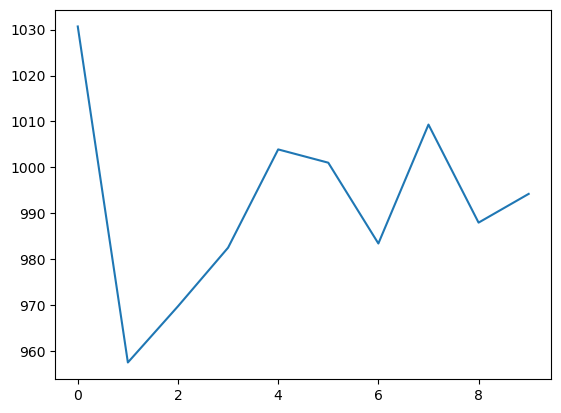

In [15]:
plt.plot(rewards)

# Optimizations

In [16]:
import cProfile

In [17]:
def stress_test():
    train_loop(custom_gym, model, games=1, optimization_passes = 1, seed=42)

In [18]:

cProfile.run('stress_test()', sort = 'time')

Training on thesis.


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Average loss 44.1355071401596
Model has been saved.

Starting evaluation on thesis (num_games=1)


Training Progress: 100%|██████████| 1/1 [00:43<00:00, 43.79s/it]

Avg reward: 1018.21  std: 451.3598408143995  coeff : 0.44328757409021663
Avg reward per agent, per game:  {1: 1448.0, 2: 692.0, 3: 1505.0, 4: 763.0, 5: 902.0, 6: 1084.0, 7: 888.0, 8: 1872.0, 9: 964.0, 10: 648.0, 11: 722.0, 12: 689.0, 13: 930.0, 14: 1875.0, 15: 994.0, 16: 1181.0, 17: 730.0, 18: 625.0, 19: 1553.0, 20: 1880.0, 21: 950.0, 22: 1147.0, 23: 1477.0, 24: 599.0, 25: 538.0, 26: 1087.0, 27: 1010.0, 28: 1026.0, 29: 2041.0, 30: 676.0, 31: 450.0, 32: 1154.0, 33: 977.0, 34: 819.0, 35: 1089.0, 36: 1051.0, 37: 820.0, 38: 931.0, 39: 2323.0, 40: 1862.0, 41: 900.0, 42: 1476.0, 43: 525.0, 44: 1051.0, 45: 901.0, 46: 808.0, 47: 1101.0, 48: 827.0, 49: 171.0, 50: 1456.0, 51: 1843.0, 52: 406.0, 53: 2328.0, 54: 559.0, 55: 573.0, 56: 611.0, 57: 296.0, 58: 1253.0, 59: 657.0, 60: 176.0, 61: 1072.0, 62: 619.0, 63: 900.0, 64: 785.0, 65: 937.0, 66: 822.0, 67: 1117.0, 68: 1423.0, 69: 723.0, 70: 1022.0, 71: 1352.0, 72: 331.0, 73: 1376.0, 74: 1209.0, 75: 1243.0, 76: 2343.0, 77: 1475.0, 78: 802.0, 79: 720.

# Visualization

In [19]:
from models.base import RenderWrapper

renderer = RenderWrapper(model=model)

In [20]:
renderer.render()